# Import module

The link to get [ImageAnalysis3](https://github.com/zhengpuas47/ImageAnalysis3) 

Or from the Zhuang lab archived [source_tools](https://github.com/ZhuangLab/Chromatin_Analysis_2020_cell/tree/master/sequential_tracing/source)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import anndata
import scanpy as sc
import os

import matplotlib.pyplot as plt

## ImageAnalysis3 and basic modules

In [2]:
# Pu's ImageAnalysis3
%run "C:\Users\shiwei\Documents\ImageAnalysis3\required_files\Startup_py3.py"
sys.path.append(r"C:\Users\shiwei\Documents")

import ImageAnalysis3 as ia
%matplotlib inline

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast


24512


## Chromatin_analysis_tools etc

See **functions** in the repository for [AnalysisTool_Chromatin](../../README.md)

In [3]:
# Chromatin_analysis_tools (ATC)
# Get path for the py containing functions
import os
import sys
import importlib
module_path =r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin'
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import relevant modules
import gene_selection 
importlib.reload(gene_selection)
import gene_to_loci
importlib.reload(gene_to_loci)
import gene_activity
importlib.reload(gene_activity)
import loci_1d_features
importlib.reload(loci_1d_features)  

import atac_to_loci
importlib.reload(atac_to_loci)

<module 'atac_to_loci' from 'C:\\Users\\shiwei\\Documents\\AnalysisTool_Chromatin\\atac_to_loci.py'>

# Define folders

In [4]:
# main folder for postanalysis
postanalysis_folder = r'L:\Shiwei\postanalysis_2024\v0'
# input files for postanalysis
input_folder = os.path.join(postanalysis_folder, 'resources_from_preprocess')

# output file to be generated
output_main_folder = os.path.join(postanalysis_folder, 'method_overview')

output_analysis_folder = os.path.join(output_main_folder, 'analysis')
output_figure_folder = os.path.join(output_main_folder, 'figures')

# make new folder if needed
make_output_folder = True

if make_output_folder and not os.path.exists(output_analysis_folder):
    os.makedirs(output_analysis_folder)
    print(f'Generating analysis folder: {output_analysis_folder}.')
elif os.path.exists(output_analysis_folder):
    print(f'Use existing analysis folder: {output_analysis_folder}.')
    
if make_output_folder and not os.path.exists(output_figure_folder):
    os.makedirs(output_figure_folder)
    print(f'Generating figure folder: {output_figure_folder}.')
elif os.path.exists(output_figure_folder):
    print(f'Use existing figure folder: {output_figure_folder}.')

Use existing analysis folder: L:\Shiwei\postanalysis_2024\v0\method_overview\analysis.
Use existing figure folder: L:\Shiwei\postanalysis_2024\v0\method_overview\figures.


# Plotting parameters

In [5]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('font', serif='Arial')

from ImageAnalysis3.figure_tools import _double_col_width, _single_col_width, _font_size, _ticklabel_size,_ticklabel_width

import seaborn as sns
sns.set_context("paper", rc={"font.size":_font_size,"axes.titlesize":_font_size+1,"axes.labelsize":_font_size})  

In [6]:
# Other required plotting parameters
_dpi = 300
_font_size = 7
_page_width = 5.5

sc.settings.n_jobs = 24
sc.settings.set_figure_params(dpi=_dpi/2, dpi_save=_dpi, frameon=False, 
                              figsize=(_page_width/2, _page_width/2), fontsize=_font_size, facecolor='white', transparent=True)
sc.settings.figdir = output_figure_folder

# Load data relevant information

## load and format codebook

[merged codebook](../resources/merged_codebook.csv) as in the repository (merged for all DNA-MERFISH libraries)

In [7]:
# Load codebook 
codebook_fname = os.path.join(input_folder,'merged_codebook.csv')
codebook_df = pd.read_csv (codebook_fname, index_col=0)

# sort df by chr and chr_order
codebook_df = loci_1d_features.sort_loci_df_by_chr_order (codebook_df)
codebook_df.head()

,name,id,NDB_784,NDB_755,NDB_826,NDB_713,NDB_865,NDB_725,NDB_817,NDB_710,...,NDB_479,NDB_562,NDB_608,NDB_460,NDB_563,NDB_592,NDB_368,NDB_436,NDB_629,NDB_604
0,1:3742742-3759944,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1:6245958-6258969,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1:8740008-8759916,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1016,1:9627926-9637875,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1017,1:9799472-9811359,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [8]:
codebook_df[codebook_df['chr']=='5']

,name,id,NDB_784,NDB_755,NDB_826,NDB_713,NDB_865,NDB_725,NDB_817,NDB_710,...,NDB_479,NDB_562,NDB_608,NDB_460,NDB_563,NDB_592,NDB_368,NDB_436,NDB_629,NDB_604
267,5:3745980-3759970,281,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1285,5:4045558-4060101,275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1286,5:4984462-4996800,277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1287,5:5266903-5275975,278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
268,5:6241707-6257332,282,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,5:147716011-147736011,Flt1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1339,5:148515091-148526288,333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
323,5:148751996-148759872,339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1340,5:150135786-150145708,334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Format the chr loci name by 
# 1. changing loci name format
# 2. extract relevant information such as id, chr, chr_order, and library etc
from gene_to_loci import loci_pos_format
loci_name_list = list(map(loci_pos_format, codebook_df['name'].tolist()))
loci_name_arr = np.array(loci_name_list)

# convert to a new dataframe and set loci name as index
codebook_df = codebook_df[['name','id','chr','chr_order','library']]
codebook_df['loci_name'] = list(loci_name_arr[:,0])
codebook_df = codebook_df.set_index ('loci_name')

codebook_df.head()

,name,id,chr,chr_order,library
loci_name,,,,,
chr1_3742742_3759944,1:3742742-3759944,1,1,0.0,CTP11
chr1_6245958_6258969,1:6245958-6258969,2,1,1.0,CTP11
chr1_8740008_8759916,1:8740008-8759916,3,1,2.0,CTP11
chr1_9627926_9637875,1:9627926-9637875,1,1,3.0,CTP13
chr1_9799472_9811359,1:9799472-9811359,2,1,4.0,CTP13


# Load m3C from neocortex


snm3C curated data can be generated using the notebook below:

[6_generate_m3C_isocortex_ensemble_HiC_matrix_bycelltype](../../../external/scripts/snm3C/6_generate_m3C_isocortex_ensemble_HiC_matrix_bycelltype.ipynb)

In [11]:
# hic result folder
hic_result_folder = r'\\crick\SSD_0\Shiwei\DNA_MERFISH_analysis\mouse_m3C'

import pickle
hic_matrix_dict_savename = os.path.join(hic_result_folder, 'm3c_isocortex_hic_matrix_by_subclass.pkl')
hic_matrix_ensemble_dict_by_subclass = pickle.load(open(hic_matrix_dict_savename,'rb'))

hic_info_dict_savename = os.path.join(hic_result_folder, 'm3c_isocortex_hic_info_by_subclass.pkl')
hic_info_ensemble_dict_by_subclass = pickle.load(open(hic_info_dict_savename,'rb'))

In [12]:
hic_matrix_ensemble_dict_by_subclass.keys()

dict_keys(['L2/3 IT', 'L4/5 IT', 'L5 IT', 'L6 IT', 'L5 ET', 'L5/6 NP', 'L6 CT', 'L6b', 'Sst', 'Pvalb', 'Lamp5', 'Sncg', 'Vip', 'Astro', 'Oligo', 'OPC', 'Micro', 'Endo', 'VLMC', 'Peri'])

In [13]:
from ImageAnalysis3.figure_tools import _double_col_width

import seaborn as sns
sns.set_context("paper", rc={"font.size":_font_size,"axes.titlesize":_font_size+1,"axes.labelsize":_font_size})   
from ImageAnalysis3.structure_tools.distance import sort_chr
from sklearn.linear_model import LinearRegression

num_cols = 7


# Load median MERFISH dict

The below **subclass_2_medianDict.pkl** and **subclass_2_cellInfo.pkl** can be generated using jupyter notebook as below:

[preprocess/2_dna_merfish/scripts/2_spot_pick/4_summarize_jie_to_dict](../../../preprocess/2_dna_merfish/scripts/2_spot_pick/4_summarize_jie_to_dict.ipynb)

In [15]:
class_2_medianDict_filename = os.path.join(input_folder, 'subclass_2_medianDict.pkl')
class_2_medianDict = pickle.load(open(class_2_medianDict_filename, 'rb'))


class_2_infoDict_filename = os.path.join(input_folder, 'subclass_2_cellInfo.pkl')
class_2_infoDict = pickle.load(open(class_2_infoDict_filename, 'rb'))

In [16]:
class_2_medianDict.keys()

dict_keys(['Oligo', 'L5 IT', 'Micro', 'Peri', 'Endo', 'Astro', 'OPC', 'L6 CT', 'L5 ET', 'L5/6 NP', 'Pvalb', 'L6 IT', 'Lamp5', 'L6b', 'Sst', 'SMC', 'L4/5 IT', 'L2/3 IT', 'Vip', 'Sncg', 'VLMC'])

# Plot distance matrices for visualization

In [17]:
import ImageAnalysis3.structure_tools.distance as distance
sort_by_region = False
chr_2_indices, chr_2_orders = distance.Generate_PlotOrder(codebook_df, codebook_df, sort_by_region=sort_by_region)

meta NOT subset; don't know how to subset; dropped
C:\Users\shiwei\AppData\Local\Temp\3\ipykernel_24512\131796243.py:55: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
meta NOT subset; don't know how to subset; dropped


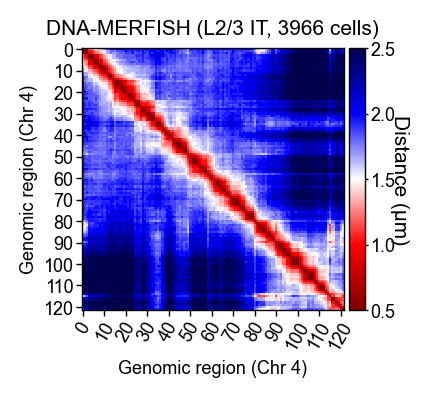

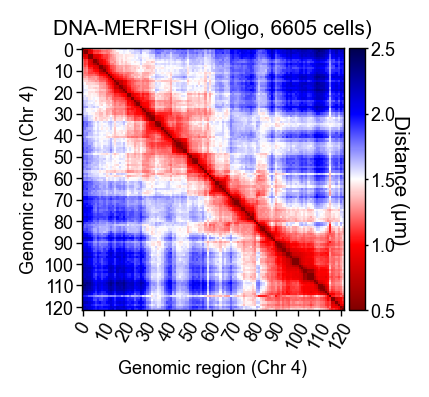

In [20]:
#%matplotlib notebook
%matplotlib inline
from matplotlib.colors import LogNorm

#plt.style.use('dark_background')
#plt.style.use('default')

_single_im_size=3
sel_codebook = codebook_df
sort_by_region = False


#_class = 'neuron'
chosen_chrom = '4'

#for _class in ['L2/3 IT', 'L6 CT','Pvalb','Astro','Oligo']:
for _class in ['L2/3 IT', 'Oligo']:
    summary_dict = class_2_medianDict[_class]

    _cis_mat, chr_edges, chr_names = distance.assemble_ChrDistDict_2_Matrix(
            summary_dict, codebook_df, 
            sel_codebook=sel_codebook, 
            use_cis=True, sort_by_region=sort_by_region,
        )

    _chr_indices = chr_2_indices[chosen_chrom]
    cis_mat_chr = _cis_mat[:,_chr_indices]
    cis_mat_chr = cis_mat_chr[_chr_indices,:]

    fig, axes = plt.subplots(1, 1, figsize=(_page_width/3.5, _page_width/3.5*1.1), dpi=100, sharex=True, sharey=True)

    ia.figure_tools.distmap.plot_distance_map(cis_mat_chr, color_limits=[0.5,2.5],
                                              ax=axes, 
                                              ticks=[i for i in np.arange(0,len(cis_mat_chr)) if i%10==0],
                                              tick_labels=[i for i in np.arange(0,len(cis_mat_chr)) if i%10==0],
                                              ax_label= f'Genomic region (Chr {chosen_chrom})', 
                                              colorbar_labels = 'Distance (\u03BCm)',
                                              colorbar_kwargs={'pad':2}, 
                                              font_size=_font_size-0.5)



    axes.set_title(f'DNA-MERFISH ({_class}, {len(class_2_infoDict[_class])} cells)', fontsize=_font_size+0.5, pad=5)
    axes.grid(False)
    axes.xaxis.set_tick_params(which='both', labelbottom=True)
    axes.yaxis.set_tick_params(which='both', labelleft=True)

    fig.subplots_adjust(wspace=0.2, hspace=0.2, left=0.05, right=0.95, top=0.97, bottom=0.02)
    #fig.suptitle(f"{_class}, N={len(class_2_chr_zxys[_class])}", fontsize=10, y=0.97)
    #fig.suptitle(f"{_class}, N={len(class_2_cellInfoList[_class])}", fontsize=10, y=0.97)
    fig.savefig(os.path.join(output_figure_folder, f"cis-distmap_{_class.replace('/','_')}_chr_{chosen_chrom}_subclass.pdf"),
                transparent=True,bbox_inches='tight', dpi=300)
    fig.show()

meta NOT subset; don't know how to subset; dropped
C:\Users\shiwei\AppData\Local\Temp\3\ipykernel_24512\482337492.py:57: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
meta NOT subset; don't know how to subset; dropped


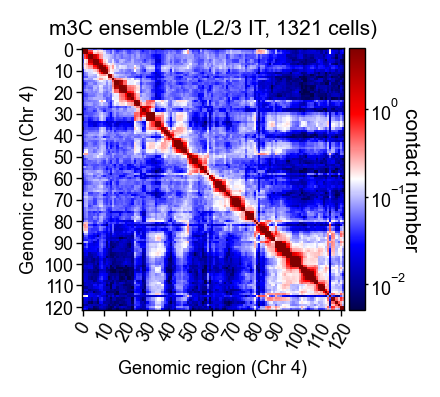

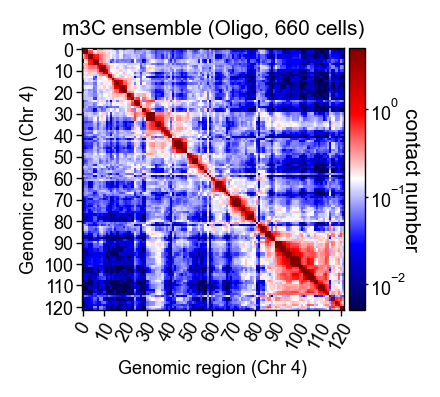

In [21]:
#%matplotlib notebook
%matplotlib inline
from matplotlib.colors import LogNorm

#plt.style.use('dark_background')
#plt.style.use('default')
_single_im_size=3
sel_codebook = codebook_df
sort_by_region = False


hic_cmap = matplotlib.cm.get_cmap('seismic')
hic_cmap.set_bad(color=[0.,0.,0.,1])
#hic_limits = [10, 5000]
hic_limits = [0.005, 5]
#hic_norm = LogNorm(vmin=np.min(hic_limits), 
          # vmax=np.max(hic_limits))

    
#for _class in ['L2/3 IT', 'L6 CT','Pvalb','Astro','Oligo']:
for _class in ['L2/3 IT', 'Oligo']:
    
    cell_number = hic_info_ensemble_dict_by_subclass[_class]['cell number'][f'chr{chosen_chrom}']
    median_hic_matrix_chr = hic_matrix_ensemble_dict_by_subclass[_class][f'chr{chosen_chrom}']
    hic_mat_chr = median_hic_matrix_chr + median_hic_matrix_chr.T - np.diag(np.diag(median_hic_matrix_chr))


    fig, axes = plt.subplots(1, 1, figsize=(_page_width/3.5, _page_width/3.5*1.1), dpi=100, sharex=True, sharey=True)


    ia.figure_tools.distmap.plot_distance_map(hic_mat_chr, 
                       cmap=hic_cmap,
                       color_limits=hic_limits,
                       #color_norm=hic_norm,
                       color_norm='log',
                       ax=axes, 
                    ticks=[i for i in np.arange(0,len(hic_mat_chr)) if i%10==0],
                    tick_labels=[i for i in np.arange(0,len(hic_mat_chr)) if i%10==0],
                       ax_label=f'Genomic region (Chr {chosen_chrom})', 
                       colorbar_labels='contact number',
                       save=False, 
                       #save_basename=fig_basename,
                        colorbar_kwargs={'pad':2}, 
                        font_size=_font_size-0.5
                       )


    axes.set_title(f'm3C ensemble ({_class}, {cell_number} cells)', fontsize=_font_size+0.5, pad=5)
    axes.grid(False)

    axes.xaxis.set_tick_params(which='both', labelbottom=True)
    axes.yaxis.set_tick_params(which='both', labelleft=True)

    fig.subplots_adjust(wspace=0.2, hspace=0.2, left=0.05, right=0.95, top=0.97, bottom=0.02)
    fig.savefig(os.path.join(output_figure_folder, f"cis-m3C_map_{_class.replace('/','_')}_chr_{chosen_chrom}_subclass.pdf"),
                transparent=True,bbox_inches='tight', dpi=300)
    fig.show()

# Plot correlation for all chromosomes

In [27]:
from sklearn.linear_model import LinearRegression
from ImageAnalysis3.structure_tools.distance import sort_chr

## L2/3 IT

In [26]:
_single_im_size=3
sel_codebook = codebook_df
sort_by_region = False

chr_2_indices, chr_2_orders = distance.Generate_PlotOrder(codebook_df, codebook_df, sort_by_region=sort_by_region)


all_sorted_chr = [str(i) for i in range(1,20)]
all_sorted_chr.append('X')
print(all_sorted_chr[:2])


_class = 'L2/3 IT'


summary_dict = class_2_medianDict[_class]
_cis_mat, chr_edges, chr_names = distance.assemble_ChrDistDict_2_Matrix(
        summary_dict, codebook_df, 
        sel_codebook=sel_codebook, 
        use_cis=True, sort_by_region=sort_by_region,
    )


# make chr_map dict from the full _cis_mat
ensemble_medianDict = {}
for _i, _chr in enumerate(all_sorted_chr):

    _chr_indices = chr_2_indices[_chr]
    cis_mat_chr = _cis_mat[:,_chr_indices]
    cis_mat_chr = cis_mat_chr[_chr_indices,:]
    
    ensemble_medianDict[f'cis_{_chr}']=cis_mat_chr

['1', '2']


meta NOT subset; don't know how to subset; dropped


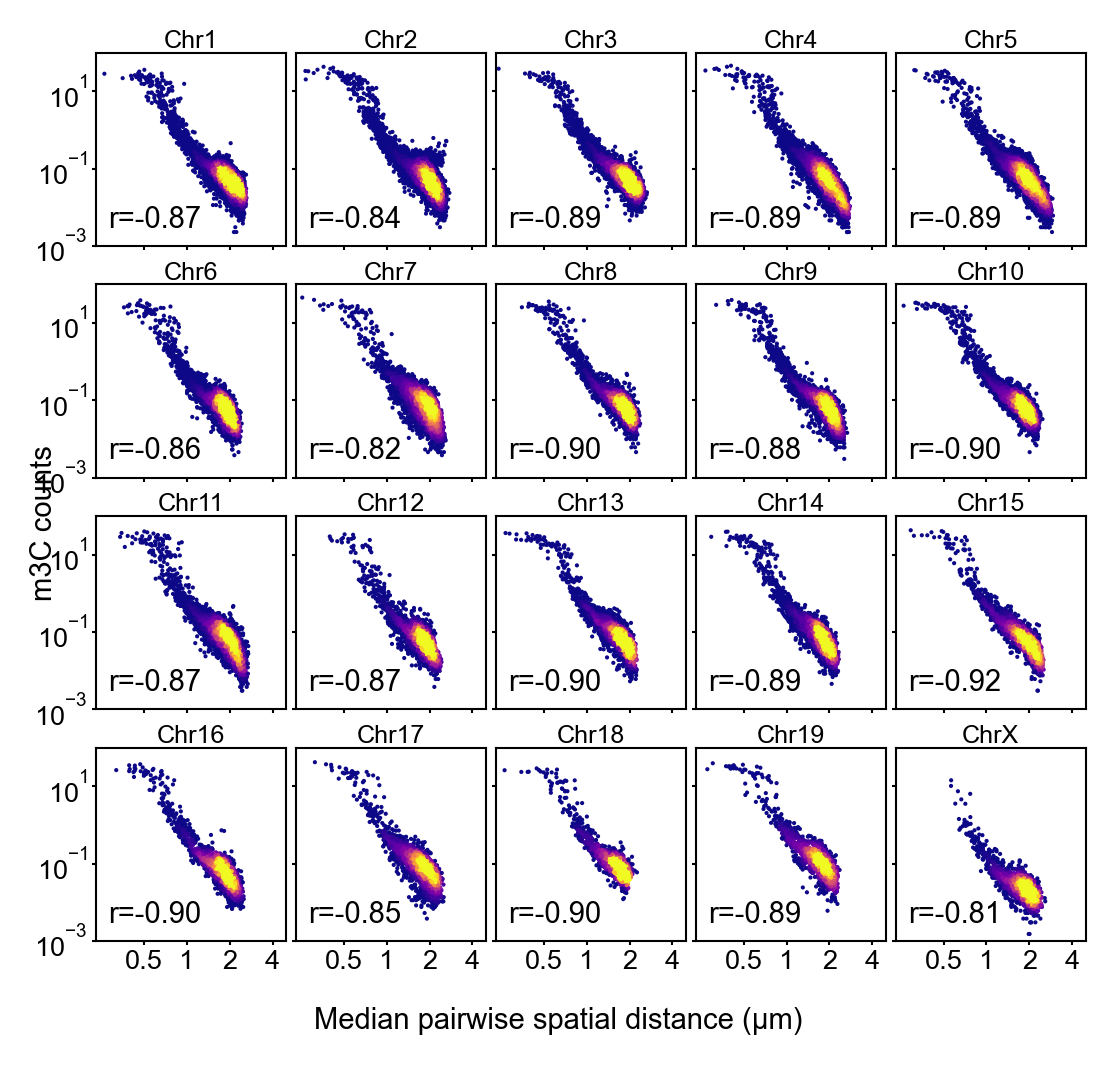

In [29]:
%matplotlib inline

from mpl_toolkits.axes_grid1 import make_axes_locatable


#plt.style.use('default')
num_rows, num_cols = 4,5

fig, axes_list = plt.subplots(num_rows, num_cols,figsize=(_page_width/1.5,_page_width/1.5*0.95), 
                              sharex=True, sharey=True, dpi=150)

_ax_list = np.ravel(axes_list)


spearman_corr_dict = {}

hic_matrix_dict = hic_matrix_ensemble_dict_by_subclass[_class]
merfish_matrix_dict = class_2_medianDict[_class]

for _i, _chr in enumerate(all_sorted_chr[:]):
    # extract axis
    _ax = _ax_list[_i]
    # extract mat for hic
    median_hic_matrix_chr = hic_matrix_dict[f'chr{_chr}']
    _hic_mat = median_hic_matrix_chr + median_hic_matrix_chr.T - np.diag(np.diag(median_hic_matrix_chr))

    # extract mat for merfish
    _median_mat = ensemble_medianDict[f'cis_{_chr}']
    
    # unravel
    _hic_entries = _hic_mat[np.triu_indices(len(_hic_mat),1)]
    _median_entries = _median_mat[np.triu_indices(len(_hic_mat),1)]
    _valid_inds = (_hic_entries > 0) & (_median_entries > 0) 
    _hic_entries = _hic_entries[_valid_inds]
    _median_entries = _median_entries[_valid_inds]
    
    # calculate color
    values = np.vstack([np.log(_median_entries), np.log(_hic_entries)])
    #values = np.vstack([(_median_entries), (_hic_entries)])
    kernel = scipy.stats.gaussian_kde(values)(values)
    vmin,vmax = scipy.stats.scoreatpercentile(kernel,10),scipy.stats.scoreatpercentile(kernel,90)
    
    # plot
    _sct = sns.scatterplot(x=_median_entries, y=_hic_entries, 
                           c=kernel, cmap='plasma', vmin=0.1, vmax=1.,
                           linewidth=0, s=1,rasterized=True,
                           ax=_ax)
    _ax.set_xscale('log')
    _ax.set_yscale('log')
    _ax.set_xticks([0.5,1,2,4])
    _ax.set_xticklabels([0.5,1,2,4])
    _ax.set_xlim([0.23, 5])
    _ax.set_ylim([0.001, 1e2])
    _ax.minorticks_off()
    # legend for coefficient
    _x = np.log(_median_entries)[:,np.newaxis]
    _y = np.log(_hic_entries)
    _reg = LinearRegression().fit(_x,_y)
    _r = -1 * np.sqrt(_reg.score(_x,_y))

    _ax.text(x=0.28, y=0.003, s=f'r={_r:.2f}', fontsize=_font_size)
    #_ax.text(x=0.28, y=7, s=f'spr={corr:.2f}', fontsize=_font_size-2)
    # title and labels
    _ax.set_title(f"Chr{_chr}", fontsize=_font_size-1, pad=1)
    # formatting
    _ax.tick_params('both', labelsize=_font_size-0.5, 
                    width=_ticklabel_width, length=_ticklabel_size-1,
                    labelleft=False,labelbottom=False, pad=1,) 
    [i[1].set_linewidth(_ticklabel_width) for i in _ax.spines.items()]
    _ax.grid(False)
    
    
# delete empty axes
for _null_ax in _ax_list[len(all_sorted_chr):]:
    fig.delaxes(_null_ax)
# 
fig.subplots_adjust(wspace=0.05, hspace=0.2, left=0.08, right=0.98, top=0.95, bottom=0.1)
# label the left most one
for _axes in axes_list:
    _axes[0].tick_params('y', labelleft=True,pad=1,) 
    
# label the bottom most row
for _ax in axes_list[-1]:
    _ax.tick_params('x', labelbottom=True,pad=1,) 
        

fig.supxlabel('Median pairwise spatial distance (\u03BCm)', fontsize=_font_size, )
fig.supylabel('m3C counts', fontsize=_font_size, )
plt.savefig(os.path.join(output_figure_folder, f"cis_correlation_scatter_median_to_m3C_{_class.replace('/','_')}.pdf"),
            transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=300)
plt.savefig(os.path.join(output_figure_folder, f"cis_correlation_scatter_median_to_m3C_{_class.replace('/','_')}.png"),
            transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=300)
plt.show()